# **Research Question 1**
#### _"Consider two classifier models, one being a neural network and the other being a variational neural network. How do these models compare in terms of in-sample and out-of-sample error on a poker dataset?"_

## Introduction
The research question above addresses two fundamental problems. The first is the comparison between a neural network (NN) and a variational neural network (vNN) on a dataset. The second is the fact that this dataset is a [poker dataset](http://poker.cs.ualberta.ca/irc_poker_database.html), which is a stochastic dataset, meaning that the dataset contains stochastic / noisy behavior from the poker players and that there is class overlap. Indeed, similar game states can still yield different actions.

As a result, this work will show what happens when a (v)NN-based classifier must train on a stochastic dataset, and will showcase the difference in performance between these two models.

### Literature
**Neural Networks (NNs)** <br>Neural networks are computational models inspired by the structure and function of the human brain (Mitchell, 2007). A neural network consists of interconnected units called neurons that work together to process and learn complex data. The basic structure of a neural network is composed of three main types of layers: input layer, hidden layer(s), and output layer.

 * The input layer receives the input data and passes it to the next layer.
 * The hidden layer(s) perform intermediate computations and apply mathematical transformations to the input data.
 * The output layer produces the final output (i.e. prediction).

Indeed, the input data propagates from the input layer, through the hidden layers, to the output layer. This process is known as forward propagation. It involves calculating the weighted sum at each neuron and applying the activation function of the neuron to the result. Indeed, the neurons are interconnected through weighted connections. The weights represent the strengths of the connections and are adjusted during the training process to improve the output. This process is repeated layer by layer until the output layer is reached. An activation function is a non-linear mathematical function applied to the weighted sum of inputs to a neuron. It introduces non-linearity and enables neural networks to model complex relationships in data. In our models, we will use the Tanh() function as the activation function for each neuron.

To calculate the performance of the neural network during training such as to be able to improve the weights correctly, we must use a loss function. A loss function measures the error between the predicted output and the true output. For this problem, we used the Mean Squared Error (MSE). The act of actually adjusting the weights based on the loss function during training happens through a process called backpropagation. It involves computing the gradient of the loss function with respect to the network's weights, and then updating the weights using an optimization algorithm such as e.g. gradient descent. This iterative process improves the model's performance over time.

Neural networks are very powerful models that can learn complex patterns and make predictions on complex data. 

**Variational Neural Networks (vNNs)** <br>Variational neural networks are a type of neural network that incorporate concepts from variational inference (Oleksiienko, 2022). The goal is to learn probabilistic representations of the data, which would allow for capturing the inherent uncertainty present in the data. During training, a vNN learns a (Gaussian) _probability distribution_ it samples from, rather than a direct output. As a result, the output of the vNN are the predictions of the mean and log-variance of the probability distribution, which are then used to sample this probability distribution and obtain the actual output value for the given input.

Using vNNs seems like a good option here, since we are dealing with a stochastic dataset, and capturing the underlying uncertainty of this dataset would be very beneficial.

### References
* Mitchell, T. M. (2007). Machine learning (Vol. 1). New York: McGraw-hill.
* Oleksiienko, I., Tran, D. T., & Iosifidis, A. (2022). Variational Neural Networks. ArXiv. /abs/2207.01524
* Poker dataset: _[Michael Maurer's IRC Poker Database](http://poker.cs.ualberta.ca/irc_poker_database.html)_

## Imports

In [1]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

## The data

### Pre-processing
The poker data consists of two lists: 
* a list of game states with the form [[private cards], [public cards], [bet history]].
* a list of actions, for each game state, where c = call, r = raise = bet = b, f = fold, k = check.

First, we must pre-process this data such that we work with vectors of bit only. There are 4 rounds: the pre-flop, the flop, the turn, and the river. At the end of all rounds, there have been 7 cards in consideration (2 private cards, 5 public cards). Each card has a rank (there are 13 ranks: 2,3,...K,A), and a suit (there are 4 suits: clubs (♣), diamonds (♦), hearts (♥), and spades (♠)). We convert each rank and each suit to a number, and then convert each number to its binary representation. 

Since for each of the 7 cards, there are 13 ranks (7 * 4 bits), 4 suits (7 * 3 bits), we get 49 bits to represent the cards. For each round, we have a maximum of 4 raises (4 * 3 bits). In total, we get a state vector of 61 bits. The actions are a one-hot encoding of 4 actions (call, raise, fold, check), so the actions are represented by 4 bits. In total, the state-actions of the poker games are represented by a vector of 65 bits.

In [2]:
#======================================#
#=== PREPROCESSING INTO VECTOR DATA ===#
#======================================#

def get_preprocessed_vector_data(preprocessed_readable_data):
    
    print("Preprocessing data into vector form.")
    # Get json converters
    with open('question_1/data/utils/rank2numbr__dataset.json', 'r') as file:
        rank2numbr = json.load(file)
    with open('question_1/data/utils/suit2index__dataset.json', 'r') as file:
        suit2index = json.load(file)

    count_games = 0
    count_states = 0
    preprocessed_vector_data = {}

    for game_id, game in preprocessed_readable_data.items():
        # Pre-process game states
        game_states = game[0]
        preprocessed_game_vector_states = []

        for game_state in game_states:
            # Get state information
            private_cards = game_state[0]
            public_cards = game_state[1]
            raises = game_state[2]
            # Create vector
            cards_vector = get_cards_vector(private_cards, public_cards, 
                                            rank2numbr, suit2index)
            raises_vector = get_raises_vector(raises)
            state = np.array(cards_vector + raises_vector)
            # Store
            preprocessed_game_vector_states.append(state.tolist())
            count_states +=1
        
        # Pre-process game actions
        game_actions = game[1]
        preprocessed_game_vector_actions = []
        action2index = {'c':[1,0,0,0], 'r':[0,1,0,0], 'b':[0,1,0,0], 
                        'f':[0,0,1,0], 'k':[0,0,0,1]}
        for action in game_actions:
            action_idx = action2index[action]
            preprocessed_game_vector_actions.append(action_idx)
        
        # Store states and actions
        preprocessed_vector_data[game_id] = \
            preprocessed_game_vector_states, preprocessed_game_vector_actions

        # Track count
        count_games +=1
        print(f"\rGames processed in vector form: {count_games:,}.", 
              end='')

    print(" (states: {:,}).".format(count_states))
    return preprocessed_vector_data

def get_cards_vector(private_cards, public_cards, 
                     rank2numbr, suit2index, card_format='rs'):
    cards_vector = []
    all_cards = private_cards+public_cards
    for card in all_cards:
        if card_format=='rs':
            rank_binary = number2binarylist(rank2numbr[card[0]], 13)
            suit_binary = number2binarylist(suit2index[card[1]], 4)
        else:
            rank_binary = number2binarylist(rank2numbr[card[1]], 13)
            suit_binary = number2binarylist(suit2index[card[0]], 4)
        cards_vector += rank_binary+suit_binary
    cards_vector += [0]*(49-len(cards_vector))
    return cards_vector

def get_raises_vector(raises):
    raises_vector = []
    for r in raises:
        binary = number2binarylist(r, 4)
        raises_vector += binary
    return raises_vector

def number2binarylist(number, max_number):
    binary_size = len(bin(max_number)[2:])
    binary = bin(number)[2:]
    binary = '0'*(binary_size-len(binary)) + binary
    binary = [int(digit) for digit in binary]
    return binary

In [3]:
#================================#
#=== VARIATIONAL AUTO-ENCODER ===#
#================================#

class VAE(nn.Module):
    def __init__(self, name, input_dim, hidden_dims, latent_dim, loss_type):
        super(VAE, self).__init__()
        self.loss_type = loss_type
        self.name = name

        # Dimensions
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim

        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc31 = nn.Linear(prev_dim, latent_dim) # mean
        self.fc32 = nn.Linear(prev_dim, latent_dim) # log variance

        # Decoder
        hidden_dims_reversed = hidden_dims[::-1]
        decoder_layers = []
        prev_dim = latent_dim
        for dim in hidden_dims_reversed:
            decoder_layers.append(nn.Linear(prev_dim, dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc31(h), self.fc32(h)

    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, z_mean, z_logvar):
        if self.loss_type == "mse":
            loss = F.mse_loss(recon_x, x, reduction='sum')
        elif self.loss_type == "bce":
            loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        elif self.loss_type == "kl": # KL Divergence
            kl_loss = -0.5 * \
                torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
            loss = kl_loss
        else:
            raise ValueError("Invalid loss type specified.")
        return loss

In [4]:
#===================#
#=== DATA IMPORT ===#
#===================#

def data_import():
    # Import dataset:
    print("\nImporting data ...")
    with open('question_1/data/poker_data__readable.json') as f:
        readable_poker_data = json.load(f)
    poker_data_dict = get_preprocessed_vector_data(readable_poker_data)

    # Store all states and actions:
    print("Storing states and actions ...")
    poker_data = []
    for game_id, game_data in poker_data_dict.items():
        game_states = game_data[0]
        game_actions = game_data[1]
        for i in range(len(game_states)):
            state = game_states[i]
            action = game_actions[i]
            poker_data.append(state+action)

    print("Done.")
    return poker_data

def data_split(split, all_data):
    # Create data split:
    data_fractions = np.cumsum(split)
    split_data = \
        np.split(all_data, (data_fractions[:-1] * len(all_data)).astype(int))
    return all_data, split_data

In [5]:
# Import data
poker_data = data_import()


Importing data ...
Preprocessing data into vector form.
Games processed in vector form: 215,537. (states: 1,024,579).
Storing states and actions ...
Done.


In [6]:
#===================#
#=== ENCODE DATA ===#
#===================#

def encode_data(poker_data):
    # VAE setup
    vae_name = "vae"
    vae_input_state_dim = 61
    vae_hidden_dims = []
    vae_latent_dim = 42
    vae_loss_type = "mse"
    # Instantiate the VAE
    vae = VAE(name=vae_name, 
            input_dim=vae_input_state_dim, 
            hidden_dims=vae_hidden_dims, 
            latent_dim=vae_latent_dim, 
            loss_type=vae_loss_type)
    # Import VAE
    vae.load_state_dict(torch.load("question_1/models/vae.pth"))

    encoded_poker_data = []
    with torch.no_grad():
        for idx, state_action in enumerate(poker_data):
            state = state_action[:vae_input_state_dim]
            action = state_action[vae_input_state_dim:]
            state_tensor = torch.tensor(state, dtype=torch.float)
            action_tensor = torch.tensor(action, dtype=torch.float)
            mu, logvar = vae.encode(state_tensor)
            latent = vae.reparameterize(mu, logvar)

            encoded_poker_data.append(latent.tolist() + action_tensor.tolist())
            print(f"\rEncoding data ({idx+1:,}/{len(poker_data):,}).", end='')
    
    print("\nDone.")
    return encoded_poker_data

In [7]:
# Encode data with VAE
encoded_poker_data = encode_data(poker_data=poker_data)

Encoding data (1,024,579/1,024,579).
Done.


### Stochasticity
Next, we will show that this data is stochastic. The `find_overlaps()` function returns the number of overlaps in the given dataset. We say an overlap occurs when a state has a duplicate somewhere in the dataset, but that state has a different action associated to it.

In [8]:
#====================#
#=== FIND OVERLAP ===#
#====================#

def find_overlaps(state_action_tensor, state_dim):
    # Definitions
    state_tensor = state_action_tensor[:, :state_dim]
    
    # Get duplicate states
    unique_states, inverse_indices, counts = torch.unique(state_tensor, 
                                                        return_inverse=True, 
                                                        return_counts=True,
                                                        dim=0)
    duplicate_states_indices = torch.nonzero(counts > 1).squeeze()
    duplicate_states = unique_states[duplicate_states_indices]

    # Count ALL state overlaps
    overlap_count = 0
    for i,state in enumerate(duplicate_states):
        duplicate_state_indices = torch.nonzero(torch.all(state_tensor == state, dim=1)).squeeze()
        duplicate_state_with_actions = state_action_tensor[duplicate_state_indices, :]

        # Check all states that have a duplicate
        first_state_action = state_action_tensor[duplicate_state_indices[0]]
        equal_state_actions = torch.all(torch.eq(duplicate_state_with_actions, first_state_action), dim=1)
        all_equal = torch.all(equal_state_actions)
        # Check if one of those duplicates has a different action
        if not all_equal:
            # If the selected state has duplicates but with different actions, 
            # that means that this state has a class overlap, so we add them to the count.
            overlap_count += len(duplicate_state_indices.tolist())
        print(f"\rNumber of overlaps found: {overlap_count:,}/{len(state_tensor):,} (Progress: {100*(i+1)/len(duplicate_states):.1f}%).", end='')

    return overlap_count

In [9]:
# Get the number of overlaps in the poker data for similar states
state_dim = 61
rounded_state_action_tensor = torch.round(torch.tensor(poker_data))
overlap_count = find_overlaps(state_action_tensor=rounded_state_action_tensor, 
                              state_dim=state_dim)

Number of overlaps found: 394,737/1,024,579 (Progress: 100.0%).

The computations above show that nearly 40% of all states have a class overlap. This shows that the dataset is very much stochastic due to the nature of the game of poker, and that the classifiers will not be able to achieve high accuracy. The question is, which model will perform better?

## The neural network (NN) classifier

### Definitions
Defining the neural network (NN) model class. The neural network takes as parameters the state dimension (i.e. input dimension), the hidden dimensions, the action dimension (i.e. output dimension), the loss function, and the activation function.

In [10]:
#======================#
#=== NEURAL NETWORK ===#
#======================#

class NN(nn.Module):
    def __init__(self, name, state_dim, hidden_dims, action_dim, 
                 loss_func, activ_func):
        super(NN, self).__init__()
        # store input params:
        self.name = name
        self.input_dim = state_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = action_dim
        self.loss_func = loss_func

        # build generator neural net:
        generator_layers = []
        prev_dim = state_dim
        for dim in hidden_dims:
            generator_layers.append(nn.Linear(prev_dim, dim))
            generator_layers.append(activ_func)
            prev_dim = dim
        generator_layers.append(nn.Linear(prev_dim, action_dim))
        generator_layers.append(nn.Sigmoid())
        self.generator_nn = nn.Sequential(*generator_layers)

    def forward(self, state):
        state = state.to(torch.float)
        action = self.generator_nn(state)
        return action

### Training
First, we define a function that will be used for testing.

In [11]:
#=====================#
#=== TEST FUNCTION ===#
#=====================#

def test_model(model, model_type, data_name, num_tests, test_data, state_dim, final_epoch):
    model.eval()
    if final_epoch: print("")

    # Track label distributions for the model and for the expert
    model_label_distr = np.array([0,0,0,0])
    expert_label_distr = np.array([0,0,0,0])

    # Determine number of tests
    if num_tests == "all":
        num_tests = len(test_data)
    elif num_tests > len(test_data) and len(test_data) != 0:
        num_tests = len(test_data)

    # Perform test
    count_gen = 0
    for i in range(num_tests):
        print(f"\rTesting on {data_name} ({100*(i+1)/num_tests:.1f}%).                   ", end='')
        # Get expert action
        state_action = test_data[i].to(torch.float)
        state = state_action[:state_dim]
        expert_label = state_action[state_dim:].to(torch.int).tolist()
        # Generate action by model
        if model_type == "nn":
            model_action = model(state)
        elif model_type == "vnn":
            model_action, mu, logvar = model(state)
        model_label = to_one_hot(model_action)
        
        # Count correct generated actions
        if expert_label == model_label:
            count_gen +=1
        
        # Update distributions
        model_label_distr += np.array(model_label)
        expert_label_distr += np.array(expert_label)
    
    # Calculate score
    model_score = 100.*count_gen/num_tests
    if final_epoch:
        print(f"\nAccuracy: {model_score:.1f}%, Expert distr: {expert_label_distr}, Model distr: {model_label_distr}", end='')

    return model_score

def to_one_hot(lst):
    # Find the index of the maximum value in the list
    max_index = max(range(len(lst)), key=lst.__getitem__)
    # Create a new list with all zeros except for a 1 at the max index
    one_hot = [0] * len(lst)
    one_hot[max_index] = 1
    return one_hot

Next, we train the NN model. We choose the number of neurons such that the data is about 10 times the number of weights. We only save the model if it beats the all time best model so far in terms of performance on the validation dataset. We specify the learning rate (lr), the batch size, and the weight decay for learning. These parameters have been chosen after a lot of testing and optimizing.

Model size: 86016
Data size: 768434
Data size / Model size: 8.93

Training: Epoch 50/50 (100.0%)                         
Testing on train data (100.0%).                   
Accuracy: 60.6%, Expert distr: [14095 18299     0 18835], Model distr: [12790 19137     0 19302]
Testing on validation data (100.0%).                   
Accuracy: 59.5%, Expert distr: [14089 18683     0 18457], Model distr: [12716 19142     0 19371]

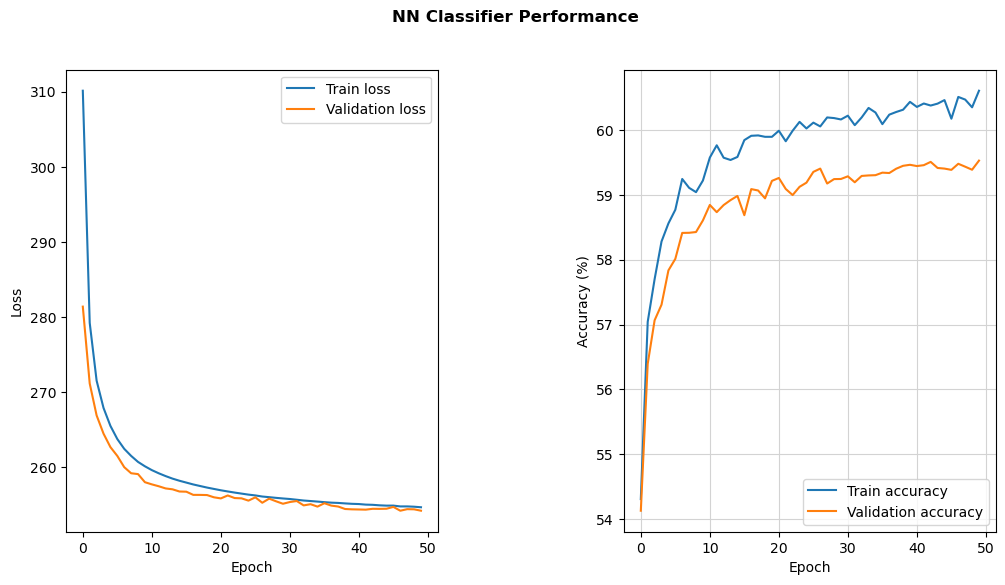

In [12]:
#===================#
#=== NN TRAINING ===#
#===================#

if __name__ == '__main__':
    # Hardware setup
    device = torch.device("cpu")
    
    # Split data
    all_data, [train_data, val_data, test_data] = data_split(all_data=encoded_poker_data,
                                                           split=[0.75, 0.05, 0.2])
    
    # Params
    name = "nn_classifier"
    save = True
    state_dim = 42
    hidden_dims = [64,8]
    action_dim = 4
    lr = 5e-4
    weight_decay = 1e-4
    batch_size = 512
    epochs = 50
    loss_func = nn.MSELoss(reduction='sum')
    activ_func = nn.Tanh()
    
    # Define model
    nn_classifier = NN(name=name, 
                       state_dim=state_dim, 
                       hidden_dims=hidden_dims, 
                       action_dim=action_dim,
                       loss_func=loss_func,
                       activ_func=activ_func)
    
    # Define optimizer
    optimizer = torch.optim.Adam(nn_classifier.parameters(), 
                                 lr=lr, 
                                 weight_decay=weight_decay)
    criterion = loss_func.to(device)
    
    # Print model and data information
    total_dimension = state_dim
    for i in range(len(nn_classifier.generator_nn)):
        if type(nn_classifier.generator_nn[i]) == nn.Linear:
            layer_dimension = len(nn_classifier.generator_nn[i].weight)
            total_dimension *= layer_dimension
    print(f"Model size: {total_dimension}")
    print(f"Data size: {len(train_data)}")
    print(f"Data size / Model size: {len(train_data)/total_dimension:.2f}\n")

    # Load model and data onto device
    nn_classifier = nn_classifier.to(device)
    train_inputs = torch.tensor(train_data[:, :state_dim])
    train_outputs = torch.tensor(train_data[:, state_dim:])
    train_dataset = TensorDataset(train_inputs, train_outputs)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_inputs = torch.tensor(val_data[:, :state_dim])
    val_outputs = torch.tensor(val_data[:, state_dim:])
    val_dataset = TensorDataset(val_inputs, val_outputs)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Train the network and plot the performance
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []
    num_epochs = epochs

    max_score = 0.0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            nn_classifier.train()
            inputs, labels = data
            optimizer.zero_grad()
            train_outputs = nn_classifier(inputs.float())
            train_loss = criterion(train_outputs, labels.float())
            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item()
            print(f"\rTraining: Epoch {epoch+1}/{epochs} ({100*(i+1)/len(train_dataloader):.1f}%)            ", end='')

        # Compute test loss
        val_loss = 0.0
        with torch.no_grad():
            nn_classifier.eval()
            for i, data in enumerate(val_dataloader):
                inputs, labels = data
                val_outputs = nn_classifier(inputs.float())
                val_loss += criterion(val_outputs, labels.float()).item()

        # Store and print statistics
        train_loss = running_loss / len(train_dataloader)
        val_loss = val_loss / len(val_dataloader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Testing
        final = True if epoch+1 == num_epochs else False
        train_score = test_model(nn_classifier, "nn", "train data", len(val_data), torch.tensor(train_data), state_dim, final)
        val_score = test_model(nn_classifier, "nn", "validation data", len(val_data), torch.tensor(val_data), state_dim, final)
        train_scores.append(train_score)
        val_scores.append(val_score)

        # Save
        if val_score > max_score and save == True:
            # Save max score
            max_score = val_score
            # Save the model
            torch.save(nn_classifier.state_dict(), f'question_1/models/{nn_classifier.name}.pth')

    # Plot performance
    epochs = range(num_epochs)

    plt.figure(figsize=(12, 6))
    plt.suptitle("NN Classifier Performance", fontweight='bold')

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_scores, label='Train accuracy')
    plt.plot(epochs, val_scores, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplots_adjust(wspace=0.5)

    plt.grid(color='lightgrey')
    plt.savefig('question_1/plots/nn_classifier.png')
    plt.show()

## The variational neural network (vNN) classifier

### Definitions
Defining the variational neural network (vNN) model class. The variational neural network takes as parameters the state dimension (i.e. input dimension), the hidden dimensions, the action dimension (i.e. output dimension), the loss function, and the activation function.

In [13]:
#==================================#
#=== VARIATIONAL NEURAL NETWORK ===#
#==================================#

class vNN(nn.Module):
    def __init__(self, name, state_dim, hidden_dims, action_dim, 
                 loss_func, activ_func):
        super(vNN, self).__init__()
        # store input params:
        self.name = name
        self.input_dim = state_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = action_dim
        self.loss_func = loss_func

        # build generator neural net:
        generator_layers = []
        prev_dim = state_dim
        for dim in hidden_dims:
            generator_layers.append(nn.Linear(prev_dim, dim))
            generator_layers.append(activ_func)
            prev_dim = dim
        generator_layers.append(nn.Linear(prev_dim, action_dim))
        generator_layers.append(nn.Sigmoid())
        self.generator_nn = nn.Sequential(*generator_layers)
        self.fc31 = nn.Linear(action_dim, action_dim) # mean
        self.fc32 = nn.Linear(action_dim, action_dim) # log variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, state):
        state = state.to(torch.float)
        action = self.generator_nn(state)
        mu = self.fc31(action)
        logvar = self.fc32(action)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

### Training
We train the vNN model. We choose the number of neurons such that the data is about 10 times the number of weights. We only save the model if it beats the all time best model so far in terms of performance on the validation dataset. We specify the learning rate (lr), the batch size, and the weight decay for learning. These parameters have been chosen after a lot of testing and optimizing.

Model size: 86016
Data size: 768434
Data size / Model size: 8.93

Training: Epoch 50/50 (100.0%)                         
Testing on train data (100.0%).                   
Accuracy: 60.4%, Expert distr: [14095 18299     0 18835], Model distr: [12557 19364     0 19308]
Testing on validation data (100.0%).                   
Accuracy: 59.4%, Expert distr: [14089 18683     0 18457], Model distr: [12658 19401     0 19170]

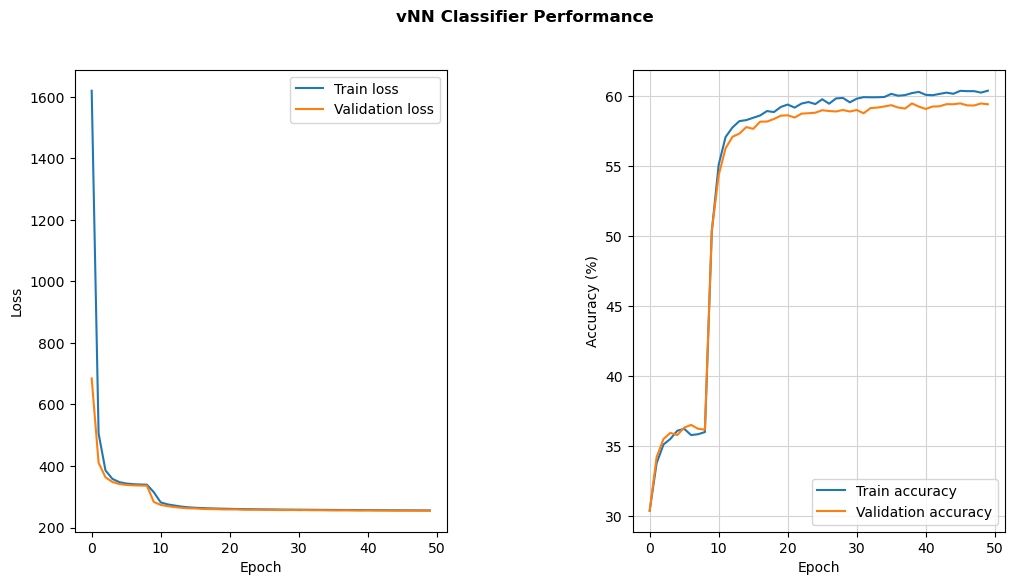

In [14]:
#====================#
#=== vNN TRAINING ===#
#====================#

if __name__ == '__main__':
    # Hardware setup
    device = torch.device("cpu")
    
    # Split data
    all_data, [train_data, val_data, test_data] = data_split(all_data=encoded_poker_data,
                                                           split=[0.75, 0.05, 0.2])
    
    # Params
    name = "vnn_classifier"
    save = True
    state_dim = 42
    hidden_dims = [64,8]
    action_dim = 4
    lr = 5e-4
    weight_decay = 1e-4
    batch_size = 512
    epochs = 50
    loss_func = nn.MSELoss(reduction='sum')
    activ_func = nn.Tanh()
    
    # Define model
    vnn_classifier = vNN(name=name, 
                        state_dim=state_dim, 
                        hidden_dims=hidden_dims, 
                        action_dim=action_dim,
                        loss_func=loss_func,
                        activ_func=activ_func)
    
    # Define optimizer
    optimizer = torch.optim.Adam(vnn_classifier.parameters(), 
                                 lr=lr, 
                                 weight_decay=weight_decay)
    criterion = loss_func.to(device)
    
    # Print model and data information
    total_dimension = state_dim
    for i in range(len(vnn_classifier.generator_nn)):
        if type(vnn_classifier.generator_nn[i]) == nn.Linear:
            layer_dimension = len(vnn_classifier.generator_nn[i].weight)
            total_dimension *= layer_dimension
    print(f"Model size: {total_dimension}")
    print(f"Data size: {len(train_data)}")
    print(f"Data size / Model size: {len(train_data)/total_dimension:.2f}\n")

    # Load model and data onto device
    vnn_classifier = vnn_classifier.to(device)
    train_inputs = torch.tensor(train_data[:, :state_dim])
    train_outputs = torch.tensor(train_data[:, state_dim:])
    train_dataset = TensorDataset(train_inputs, train_outputs)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_inputs = torch.tensor(val_data[:, :state_dim])
    val_outputs = torch.tensor(val_data[:, state_dim:])
    val_dataset = TensorDataset(val_inputs, val_outputs)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Train the network and plot the performance
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []
    num_epochs = epochs

    max_score = 0.0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            vnn_classifier.train()
            inputs, labels = data
            optimizer.zero_grad()
            train_outputs, mu, logvar = vnn_classifier(inputs.float())
            train_loss = criterion(train_outputs, labels.float())
            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item()
            print(f"\rTraining: Epoch {epoch+1}/{epochs} ({100*(i+1)/len(train_dataloader):.1f}%)            ", end='')

        # Compute test loss
        val_loss = 0.0
        with torch.no_grad():
            vnn_classifier.eval()
            for i, data in enumerate(val_dataloader):
                inputs, labels = data
                val_outputs, _, _ = vnn_classifier(inputs.float())
                val_loss += criterion(val_outputs, labels.float()).item()

        # Store and print statistics
        train_loss = running_loss / len(train_dataloader)
        val_loss = val_loss / len(val_dataloader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Testing
        final = True if epoch+1 == num_epochs else False
        train_score = test_model(vnn_classifier, "vnn", "train data", len(val_data), torch.tensor(train_data), state_dim, final)
        val_score = test_model(vnn_classifier, "vnn", "validation data", len(val_data), torch.tensor(val_data), state_dim, final)
        train_scores.append(train_score)
        val_scores.append(val_score)

        # Save
        if val_score > max_score and save == True:
            # Save max score
            max_score = val_score
            # Save the model
            torch.save(vnn_classifier.state_dict(), f'question_1/models/{vnn_classifier.name}.pth')

    # Plot performance
    epochs = range(num_epochs)

    plt.figure(figsize=(12, 6))
    plt.suptitle("vNN Classifier Performance", fontweight='bold')

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_scores, label='Train accuracy')
    plt.plot(epochs, val_scores, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplots_adjust(wspace=0.5)

    plt.grid(color='lightgrey')
    plt.savefig('question_1/plots/vnn_classifier.png')
    plt.show()

## Testing
We will now test the error and accuracy on the test set.

In [15]:
# Setting the data
test_inputs = torch.tensor(test_data[:, :state_dim])
test_outputs = torch.tensor(test_data[:, state_dim:])
test_dataset = TensorDataset(test_inputs, test_outputs)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
# Load best saved models
nn_classifier.load_state_dict(torch.load("question_1/models/nn_classifier.pth"))
vnn_classifier.load_state_dict(torch.load("question_1/models/vnn_classifier.pth"))

<All keys matched successfully>

### Test of the NN classifier

In [17]:
# Compute test loss
nn_test_loss = 0.0
with torch.no_grad():
    nn_classifier.eval()
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        test_outputs = nn_classifier(inputs.float())
        nn_test_loss += criterion(test_outputs, labels.float()).item()

print(f"NN model: test loss = {nn_test_loss:.1f}")

NN model: test loss = 104302.0


In [18]:
# Compute test accuracy
nn_test_score = test_model(nn_classifier, "nn", "test data", len(test_data), torch.tensor(test_data), state_dim, True)
print(f"\nNN model: test accuracy = {nn_test_score:.1f}%.")


Testing on test data (100.0%).                   
Accuracy: 58.6%, Expert distr: [58456 76839     0 69621], Model distr: [53322 79454     0 72140]
NN model: test accuracy = 58.6%.


### Test of the vNN classifier

In [19]:
# Compute test score
vnn_test_loss = 0.0
with torch.no_grad():
    vnn_classifier.eval()
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        test_outputs, _, _ = vnn_classifier(inputs.float())
        vnn_test_loss += criterion(test_outputs, labels.float()).item()

print(f"vNN model: test loss = {vnn_test_loss:.1f}")

vNN model: test loss = 104714.7


In [20]:
# Compute test accuracy
vnn_test_score = test_model(vnn_classifier, "vnn", "test data", len(test_data), torch.tensor(test_data), state_dim, True)
print(f"\nvNN model: test accuracy = {vnn_test_score:.1f}%.")


Testing on test data (100.0%).                   
Accuracy: 58.4%, Expert distr: [58456 76839     0 69621], Model distr: [53417 82037     0 69462]
vNN model: test accuracy = 58.4%.


### Comparison

In [24]:
# Calculate differences
loss_difference = 100 * nn_test_loss / vnn_test_loss
score_difference = 100 * nn_test_score / vnn_test_score

print(f"The NN has a {100-loss_difference:.2f}% lower loss.")
print(f"The NN has a {score_difference-100:.2f}% higher accuracy.")

The NN has a 0.39% lower loss.
The NN has a 0.25% higher accuracy.


## Conclusion
Our goal was to find out how well a NN classifier and a vNN classifier can learn a stochastic dataset such as a poker dataset, and which model is best.

In terms of how well these models learn the data, both barely manage to reach 60% accuracy on the training set, and seem to plateau at this value. The models hit accuracies on the validation set and test set that are close to 60%, indicating that these models are most likely not overfitting. The results also show that the models seem to learn the distribution of actions well, with an appropriate proportion of call, raises, folds, and checks w.r.t. the experts in the dataset. This project was meant to include the performance on a poker engine, however, it was not possible to include this inside the notebook without cluttering the codebase with massive amounts of code. However, the tests were performed outside this notebook, and show that these models actually play poker very well. They beat a random poker agent by over 2000mbb/h, which is huge considering the fact that professional players consider that beating an opponent by 200mbb/h is significant. To conclude on the learning ability of both models, the accuracy seems low due to the stochastic nature of the dataset causing class overlaps, but the actual performance in poker games is good, meaning that the models do learn the poker data to a significant extent.

The next aspect to assess is which model performs best between the two. Based on the results above, the NN classifier performs very slightly better than the vNN classifier. However, the difference is extremely small, at less than 1% for both loss and accuracy, meaning there is no strong conclusion on which model is best in terms of performance, and both models should be considered equivalent on that front. A more noticable difference, however, is the difference in learning speeds. The NN classifier converges significantly faster than the vNN classifier for the same parameters and the same epochs. For instance, the plots below show that the NN requires 1 epoch to reach 55% accuracy, while the vNN requires 10 epochs to do so.

<br>

![NN performance](question_1/plots/nn_classifier.png)
![vNN performance](question_1/plots/vnn_classifier.png)

# **Research Question 2**
#### _"insert question 2"_